# Imports

In [1]:
from src.spectrum import (
    LinealEnergySpectrum,
    SpectrumData,
    SpectrumValueType,
    SpecificEnergySpectrum,
    specific_energy_spectum,
)
from src.paths import project_dir
import numpy as np
import matplotlib
import pandas as pd

%matplotlib inline
import matplotlib.pylab as plt
from dataclasses import dataclass, field

In [2]:
!python -V

Python 3.9.8


# Single event spectra for low energy photons

## Raw Data

In [3]:
@dataclass(frozen=True)
class Metadata:
    filename: str = ""
    site_diam_um: float = np.nan
    energy_keV: float = np.nan

    def __post_init__(self):
        object.__setattr__(
            self,
            "filename",
            f"Xrays_{self.energy_keV:.0f}keV_{self.site_diam_um:.1f}um_ydy.csv",
        )

In [4]:
@dataclass(frozen=True)
class Data:
    metadata: Metadata = field(default_factory=lambda: Metadata)
    spectrum_y: LinealEnergySpectrum = field(
        default_factory=lambda: LinealEnergySpectrum()
    )
    spectrum_z: SpecificEnergySpectrum = field(
        default_factory=lambda: SpecificEnergySpectrum()
    )

    def __post_init__(self):
        spectrum_y = LinealEnergySpectrum.from_csv(
            file_path=project_dir / "data" / "interim" / self.metadata.filename,
            delimiter=",",
            value_type=SpectrumValueType.ydy,
        )
        object.__setattr__(self, "spectrum_y", spectrum_y)
        object.__setattr__(
            self,
            "spectrum_z",
            specific_energy_spectum(
                spectrum_y, site_diam_um=self.metadata.site_diam_um
            ),
        )

In [5]:
site_diam_um = (0.5, 1, 2)
dataset_metadata = [Metadata(site_diam_um=diam, energy_keV=12) for diam in site_diam_um]
dataset_metadata

[Metadata(filename='Xrays_12keV_0.5um_ydy.csv', site_diam_um=0.5, energy_keV=12),
 Metadata(filename='Xrays_12keV_1.0um_ydy.csv', site_diam_um=1, energy_keV=12),
 Metadata(filename='Xrays_12keV_2.0um_ydy.csv', site_diam_um=2, energy_keV=12)]

In [6]:
dataset = [Data(metadata=metadata) for metadata in dataset_metadata]

## f1 y spectrum

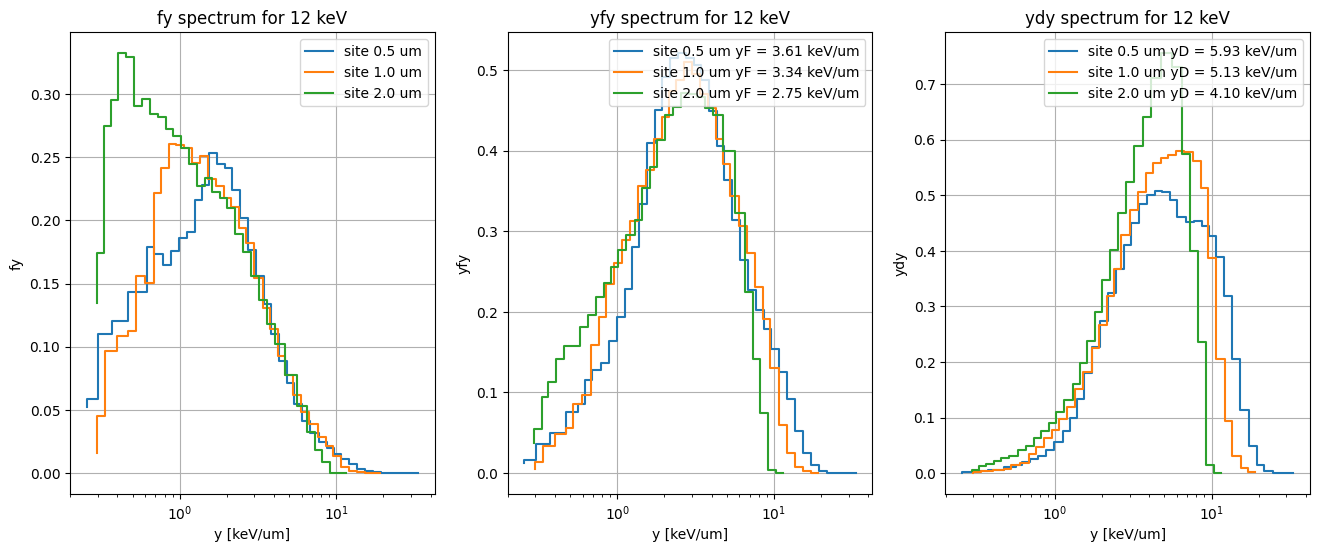

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
for data in dataset:
    spectrum_z = data.spectrum_y
    ax[0].step(
        spectrum_z.data.bin_edges[1:],
        spectrum_z.fy,
        label=f"site {data.metadata.site_diam_um:.1f} um",
    )
    ax[1].step(
        spectrum_z.data.bin_edges[1:],
        spectrum_z.yfy,
        label=f"site {data.metadata.site_diam_um:.1f} um yF = {spectrum_z.yF:.2f} keV/um",
    )
    ax[2].step(
        spectrum_z.data.bin_edges[1:],
        spectrum_z.ydy,
        label=f"site {data.metadata.site_diam_um:.1f} um yD = {spectrum_z.yD:.2f} keV/um",
    )
ax[0].set_ylabel("fy")
ax[1].set_ylabel("yfy")
ax[2].set_ylabel("ydy")
ax[0].set_title("fy spectrum for 12 keV")
ax[1].set_title("yfy spectrum for 12 keV")
ax[2].set_title("ydy spectrum for 12 keV")

for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("y [keV/um]")
    a.legend(loc="upper right")

## f1 z spectrum

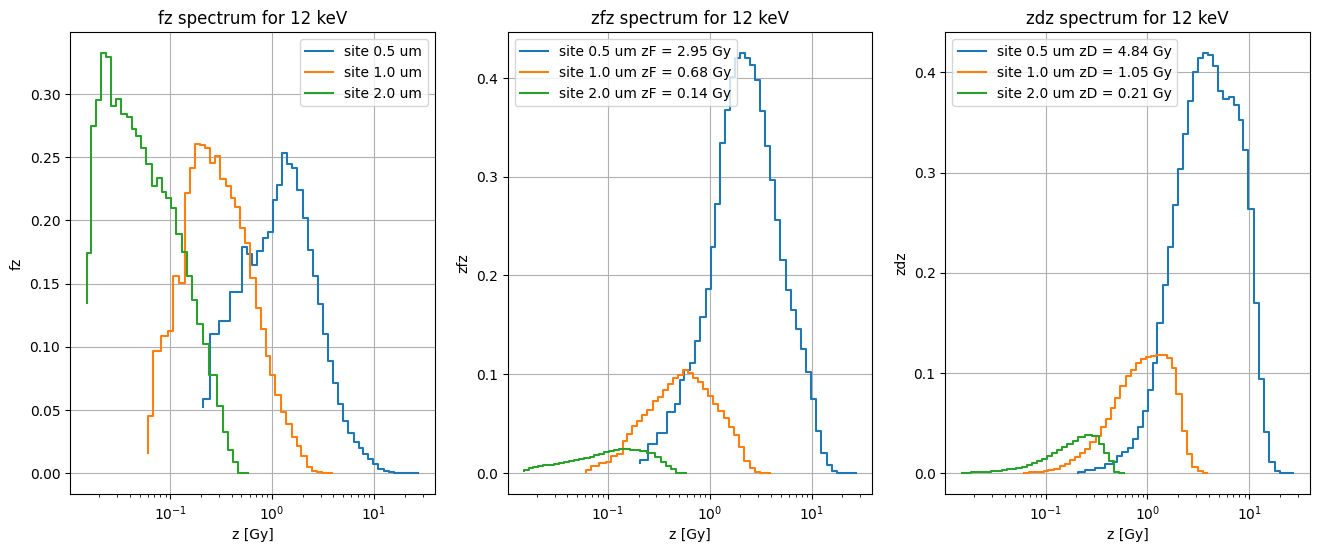

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
for data in dataset:
    spectrum_z = data.spectrum_z
    ax[0].step(
        spectrum_z.data.bin_edges[1:],
        spectrum_z.fz,
        label=f"site {data.metadata.site_diam_um:.1f} um",
    )
    ax[1].step(
        spectrum_z.data.bin_edges[1:],
        spectrum_z.zfz,
        label=f"site {data.metadata.site_diam_um:.1f} um zF = {spectrum_z.zF:.2f} Gy",
    )
    ax[2].step(
        spectrum_z.data.bin_edges[1:],
        spectrum_z.zdz,
        label=f"site {data.metadata.site_diam_um:.1f} um zD = {spectrum_z.zD:.2f} Gy",
    )
ax[0].set_ylabel("fz")
ax[1].set_ylabel("zfz")
ax[2].set_ylabel("zdz")
ax[0].set_title("fz spectrum for 12 keV")
ax[1].set_title("zfz spectrum for 12 keV")
ax[2].set_title("zdz spectrum for 12 keV")

for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("z [Gy]")
    a.legend()

# Excel export

In [9]:
spectra_output_file = project_dir / "data" / "processed" / "spectra.xlsx"
with pd.ExcelWriter(spectra_output_file, mode="w") as writer:
    for data in dataset:
        df = pd.DataFrame(
            {
                "y": data.spectrum_y.data.bin_centers,
                "fy": data.spectrum_y.fy,
                "yfy": data.spectrum_y.yfy,
                "ydy": data.spectrum_y.ydy,
                "z": data.spectrum_z.data.bin_centers,
                "fz": data.spectrum_z.fz,
                "zfz": data.spectrum_z.zfz,
                "zdz": data.spectrum_z.zdz,
            }
        )
        df.to_excel(
            writer,
            sheet_name=f"{data.metadata.energy_keV:.0f}keV_{data.metadata.site_diam_um:.1f}um",
        )